# 3) Déterminants du prix des hôtels

In [1]:
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
import os
path = os.getcwd()
os.chdir(path)

In [3]:
df = pd.read_excel('dfhotels_merged.xlsx')
df.head()

,Hôtels,Note moyenne,Nombre de commentaires,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5


In [4]:
df = df.rename(columns={'Nombre de commentaires':'Nb_comms', 'Note moyenne':'Note_moy'})
df.head()

,Hôtels,Note_moy,Nb_comms,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5


In [5]:
nb_tot_hotels = len(df)
nb_tot_hotels

428

# 3.1. Etude de la représentativité des données scrapées

Avant d'affirmer que nos modèles de prédiction des prix des hôtels à Paris sont cohérents avec la réalité, il faut d'abord s'assurer que nos données sont suffisamment représentatives. Pour cela, on peut (par exemple) vérifier que l'on dispose d'une proportion d'hôtels par arrondissement (par rapport à l'ensemble de la base) suffisamment proche des proportions réelles.

On cherche donc à créer un graphique montrant la répartition du nombre d'hôtels par arrondissement. On procède en deux temps :

1) Création d'une sous-base de données avec le nombre d'hôtels par arrondissement rapporté au nombre total d'hôtels de la base initiale

2) Représentation graphique de ce nombre d'hôtels par arrondissement rapporté au nombre total d'hôtels

In [6]:
df[['Arrondissement','Hôtels']].groupby('Arrondissement').count().sort_values(by='Hôtels', ascending=False).head()

,Hôtels
Arrondissement,
9,55
8,47
17,32
15,31
10,29


On constate déjà que ce sont les hôtels des arrondissements 8 et 9 qui sont les plus représentés dans notre base de données. Cette répartition ne semble pas avoir de lien avec la position géographique puisque les arrondissements 8 et 9 sont situés respectivement au centre-nord et au sud de Paris.

In [7]:
nbr_hotel = df[['Arrondissement','Hôtels']].groupby('Arrondissement').count().sort_values(by='Arrondissement', ascending=True)
nbr_hotel.reset_index(0, inplace=True)
nbr_hotel.rename(columns={'Hôtels':'Nb_Hôtels'}, inplace=True)
nbr_hotel['Proportion empirique'] = nbr_hotel['Nb_Hôtels']/nb_tot_hotels
nbr_hotel.head()

,Arrondissement,Nb_Hôtels,Proportion empirique
0,1,18,0.042056
1,2,16,0.037383
2,3,7,0.016355
3,4,7,0.016355
4,5,21,0.049065


Comparons maintenant ce graphique avec celui qu'on obtient à partir des données officielles (https://fr.statista.com/statistiques/494957/part-hotel-paris-france-arrondissement/). Les données sont reportées ici à la main.

In [8]:
arr_reel = [i for i in range(1,21)]
hot_par_arr_reel = [75,47,30,38,83,105,63,146,184,128,84,78,47,101,103,71,129,77,24,31]

In [9]:
nb_tot_reel = sum(hot_par_arr_reel)

In [10]:
prop_reelle = [x / nb_tot_reel for x in hot_par_arr_reel]

In [11]:
nbr_hotel['Proportion réelle'] = prop_reelle
nbr_hotel.head()

,Arrondissement,Nb_Hôtels,Proportion empirique,Proportion réelle
0,1,18,0.042056,0.045620
1,2,16,0.037383,0.028589
2,3,7,0.016355,0.018248
3,4,7,0.016355,0.023114
4,5,21,0.049065,0.050487


Pour pouvoir afficher l'histogramme avec les deux valeurs (proportion empirique et proportion réelle) pour chaque arrondissement, une méthode consiste à faire un "unpivot" de notre dataframe. 

In [12]:
nbr_hotel2 = nbr_hotel.copy()
del nbr_hotel2['Nb_Hôtels']
nbr_hotel2 = nbr_hotel2.melt(id_vars = 'Arrondissement', var_name = 'Type', value_name = 'Proportion')
nbr_hotel2.head()

,Arrondissement,Type,Proportion
0,1,Proportion empirique,0.042056
1,2,Proportion empirique,0.037383
2,3,Proportion empirique,0.016355
3,4,Proportion empirique,0.016355
4,5,Proportion empirique,0.049065


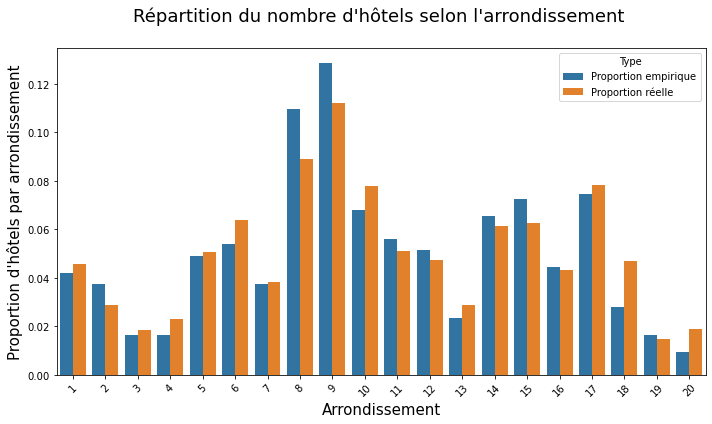

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(x="Arrondissement", y="Proportion", hue="Type", data=nbr_hotel2)
plt.xlabel('Arrondissement', fontsize=15)
plt.ylabel("Proportion d'hôtels par arrondissement", fontsize=15)
plt.title("Répartition du nombre d'hôtels selon l'arrondissement \n", fontsize=18)
plt.xticks(rotation= 45)
plt.tight_layout()

À première vue, notre échantillon semble représentatif car les proportions empiriques et théoriques sont relativement proches pour chaque arrondissement. Pour être rigoureux, on peut effectuer un test de chi-deux, qui est un test de représentativité d'un échantillon à partir d'une seule variable prenant $k$ modalités (source : "http://sspsd.u-strasbg.fr/IMG/pdf/Cours_seance_3_et_4.pdf" ; ici, ces modalités sont les arrondissements). Ce test est construit à partir de la variable suivante, qui peut être interprétée comme une distance entre les effectifs empiriques (les $n_i$) et les effectifs théoriques construits à partir de la taille de l'échantillon (les $n p_i$, où $n$ est la taille de l'échantillon observé et où les $p_i$ désignent les proportions théoriques).

$$ \chi^2 = \sum_{i=1}^k \frac{(n_i - n p_i)^2}{n p_i} $$

In [14]:
nbr_hotel["Taille de l'échantillon"] = nb_tot_hotels
nbr_hotel["Effectifs théoriques"] = nbr_hotel["Taille de l'échantillon"]*nbr_hotel["Proportion réelle"]
nbr_hotel.head()

,Arrondissement,Nb_Hôtels,Proportion empirique,Proportion réelle,Taille de l'échantillon,Effectifs théoriques
0,1,18,0.042056,0.045620,428,19.525547
1,2,16,0.037383,0.028589,428,12.236010
2,3,7,0.016355,0.018248,428,7.810219
3,4,7,0.016355,0.023114,428,9.892944
4,5,21,0.049065,0.050487,428,21.608273


On calcule désormais la statistique de test selon la formule donnée ci-dessus.

In [15]:
sum([(nbr_hotel['Nb_Hôtels'][arr] - nbr_hotel["Effectifs théoriques"][arr])**2 / nbr_hotel["Effectifs théoriques"][arr] for arr in range(len(nbr_hotel))])  

13.64425137489156

Cette valeur obtenue n'est pas satisfaisante. En effet, elle est au-delà de la valeur (10,117) qui aurait pu nous garantir avec un risque de première espèce de 5% que nos données sont représentatives. Ici, on peut seulement l'affirmer avec un risque de première espèce de 20% (ce qui est considérable). On décide malgré tout de conserver notre jeu de données.

(lien vers la table : https://www.soft-concept.com/surveymag/images/posts/lexique-etudes-marketing-table-du-khi2.jpg)

# 3.2. Analyse descriptive du jeu de données

## 3.2.1. Analyse du nombre d'étoiles des hôtels

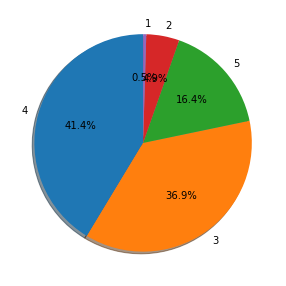

In [16]:
nbr_Etoil= df["Etoiles"].value_counts()
plt.rcParams["figure.figsize"]=[5,5]
plt.pie(nbr_Etoil.values, labels=nbr_Etoil.index, autopct='%1.1f%%',shadow=True, startangle=90)
plt.draw()

On peut constater que les hôtels 4 étoiles et 3 étoiles sont les plus représentés dans notre jeu de données, en surnombre avec des proportions respectives de 41,4 % et 36,9%. 

## 3.2.2. Les facteurs d'influence des prix des hôtels

In [17]:
df["Prix"].describe()

count    428.000000
mean     163.754673
std       61.107753
min       72.000000
25%      119.750000
50%      149.500000
75%      204.250000
max      523.000000
Name: Prix, dtype: float64

On constate que les prix de réservation varient entre 72 et 523 euros. Il existe un "noyau dur" d'hôtels pour lesquels le prix de réservation varie entre 120 et 204 euros. La valeur de l'écart-type nous suggère une forte dispersion des prix entre les hôtels.

On décide de représenter la dispersion des prix grâce à une boîte à moustaches.

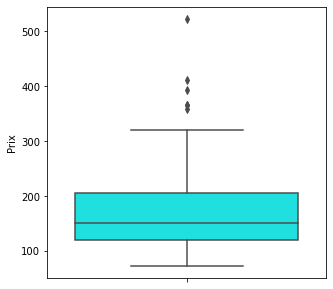

In [18]:
sns.boxplot(data = df
            ,y = 'Prix'
            ,color = 'cyan'
            )
plt.rcParams["figure.figsize"]=[2,2]

En observant le graphique ci-dessus, nous pouvons voir que la distribution du prix des hôtels n'est pas homogène. Cela s'observe notamment par le fait que la médiane n'est pas centrée dans la boite, et par le fait que les valeurs extrêmes sont assez éloignées de la boîte.


Nous affinons cette analyse en étudiant la dispersion des prix selon le nombre d'étoiles des hôtels.

#### Le nombre d'étoiles, facteur de dispersion des prix

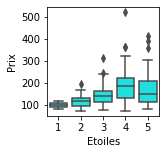

In [19]:
sns.boxplot(data = df
            ,y= 'Prix'
            ,x='Etoiles'
            ,color = 'cyan'
            )
plt.rcParams["figure.figsize"]=[5,5]

Comme on pouvait s'y attendre, le nombre d'étoiles influe sur la dispersion des prix des hôtels. Ainsi, les hôtels à 1 étoile ont des prix concentrés autour de 100 euros, alors que les hôtels à 4 et 5 étoiles voient leurs prix fluctuer entre 75 et 500 euros. 

#### Etude des prix moyens selon les arrondissements

On s'intéresse désormais au lien existant entre les prix et l'arrondissement. Certains arrondissements possèdent en effet des caractéristiques propres (tels que la sécurité ou la richesse, que l'on étudiera juste après), qui peuvent influer sur les prix.

In [20]:
Arr_prix= df[['Arrondissement','Prix']].groupby('Arrondissement').mean().sort_values(by='Prix', ascending= False)
Arr_prix.reset_index(0, inplace=True)
Arr_prix.rename(columns={'Prix':'Prix_Moyen'}, inplace=True)
Arr_prix.head(10)

,Arrondissement,Prix_Moyen
0,1,226.666667
1,2,209.625000
2,7,200.875000
3,6,189.739130
4,4,189.571429
5,8,189.000000
6,16,184.789474
7,9,167.800000
8,5,159.380952
9,17,159.062500


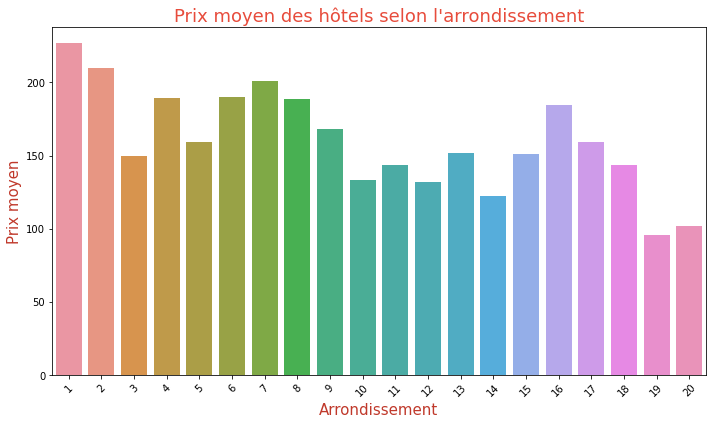

In [21]:
plt.figure(figsize=(10,6))
sns.barplot(x=Arr_prix['Arrondissement'], y=Arr_prix['Prix_Moyen'])
plt.xlabel('Arrondissement', fontsize=15, color='#c0392b')
plt.ylabel("Prix moyen", fontsize=15, color='#c0392b')
plt.title("Prix moyen des hôtels selon l'arrondissement", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

Par observation du graphique, on remarque que les prix moyens des chambres varient selon l'arrondissement. Les prix moyens les plus élévés sont observés dans le 1er et le 7ème arrondissements qui apparaissent comme des arrondissements riches selon le classement par impôt moyen de 2010 (https://www.journaldunet.com/economie/magazine/1097263-les-riches-a-paris-arrondissement-par-arrondissement/1097285-classement)". Cela nous incite à nous intéresser plus en détails à la relation entre la richesse d'un arrondissement et le prix des hôtels (on étudiera cette relation plus tard). 

## 3.2.3. Analyse des notes sur les caractéristiques des chambres

Les notes données par les clients portaient sur 7 caractéristiques : la qualité du personnel, l'équipement, la propreté, le confort, le rapport qualité/prix, la situation géographique et la qualité du réseau Wi-Fi. Le site Booking.com nous fournit également la note moyenne, qui constitue une première base d'analyse.

Ces notes attribuées entre 0 et 10 expriment la satisfaction des usagers. Selon l'échelle de Likert (https://www.appvizer.fr/magazine/marketing/sondages-et-questionnaires/comment-choisir-echelle-d-attitude-questionnaire-de-satisfaction#id3), ces notes peuvent être interprétées de la façon suivante :

- 9-10 : Très satisfait
- 7-8 : Satisfait
- 5-6 : Ni satisfait, ni insatisfait
- 2-4 : Peu satisfait
- 0-1 : Pas du tout satisfait.

#### Moyenne générale

In [22]:
df[['Note_moy']].describe()

,Note_moy
count,428.000000
mean,8.257243
std,0.500322
min,6.800000
25%,7.900000
50%,8.300000
75%,8.600000
max,9.600000


On constate que les notes moyennes vont de 6,8 à 9,6 sur 10 avec une note moyenne de 8.25. La valeur de l'écart-type semble nous indiquer une faible dispersion de ces notes.

#### Analyse de la note des autres commodités du logement

Approfondissons cette analyse en étudiant les notes pour chaque critère.

In [23]:
df[['perso','equip','prop','conf','rap_qp','situ','wifi']].describe()

,perso,equip,prop,conf,rap_qp,situ,wifi
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.00000
mean,8.895093,8.958178,8.594159,8.250234,8.229439,7.950234,8.34486
std,0.500631,0.511876,0.549122,0.608353,0.546115,0.566327,0.63890
min,6.400000,6.300000,6.700000,6.500000,6.700000,6.200000,6.10000
25%,8.600000,8.700000,8.300000,7.800000,7.900000,7.600000,7.97500
50%,9.000000,9.000000,8.650000,8.300000,8.300000,8.000000,8.40000
75%,9.300000,9.300000,9.000000,8.700000,8.600000,8.300000,8.80000
max,9.900000,9.800000,9.700000,9.600000,9.400000,9.500000,10.00000


Le tableau ci-dessus montre que 75% des hôtels ont une moyenne satisfaisante en ce qui concerne l'ensemble des commodités (par observation du premier quartile). On note de plus que les usagers sont en majorité très satisfaits par le service du personnel et l'équipement des chambres (la moitié des hôtels ont obtenu une note d'au moins 9 pour ces deux caractéristiques). 

# 3.3. Création d'un modèle de régression

## 3.3.1. Création d'une variable binaire sur la "richesse" et la sûreté d'un arrondissement

Les numéros d'arrondissement constituant une variable catégorielle (difficilement exploitable pour une régression), on décide de nous en servir pour connaître quelques caractéristiques supplémentaires sur l'emplacement des hôtels, qui peuvent éventuellement influencer leur prix. On voudrait notamment savoir si l'arrondissement dans lequel est situé un hôtel est réputé "riche" ou "pauvre". 

Pour cela, on se fie à l'indicateur du nombre d'imposés à l'ISF par arrondissement en 2010 donné par la Direction Générale des Finances Publiques (https://www.journaldunet.com/economie/magazine/1097263-les-riches-a-paris-arrondissement-par-arrondissement/1097285-classement). On décide de considérer comme "riche" un arrondissement dans lequel l'impôt moyen est supérieur à 8 000 € (sur l'année).

On créé donc une variable binaire "Riche" valant 1 si l'arrondissement de l'hôtel appartient à la liste des arrondissements réputés "riches" et 0 sinon.

In [24]:
df['Riche'] = [1 if arr in [16,17,7,6,8,4,1] else 0 for arr in df['Arrondissement']]
df.head()

,Hôtels,Note_moy,Nb_comms,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi,Riche
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8,0
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3,0
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0,1
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9,0
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5,0


On peut également créer une variable "Sécurité" valant 1 si l'arrondissement est réputé pour être sûr et 0 sinon. Pour cela, on décide d'utiliser une enquête du Parisien (https://www.leparisien.fr/info-paris-ile-de-france-oise/bien-vivre-en-ile-de-france-notre-palmares-a-paris-22-09-2017-7278876.php) en indiquant la sécurité comme seul critère de bien-être (on aurait pu en inclure d'autres, mais nous disposons déjà de notes pour la plupart des autres critères). On décide de considérer comme "sûr" un arrondissement dans lequel le score sur le critère "Sécurité" est supérieur à 80/100.

In [25]:
df['Sûr'] = [1 if arr in [4,5,6,7,15,16,1,2,3,8,12] else 0 for arr in df['Arrondissement']]
df.head()

,Hôtels,Note_moy,Nb_comms,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi,Riche,Sûr
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8,0,1
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3,0,0
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0,1,0
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9,0,0
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5,0,0


## 3.3.2. Corrélations entre variables

Avant de lancer un modèle de régression linéaire, il paraît judicieux de regarder sur des graphiques les relations entre notre variable d'intérêt (les prix) et nos variables explicatives. Par exemple, si l'on remarque une relation quadratique, on préfèrera mettre notre variable explicative au carré dans le modèle de régression. De plus, nos graphiques nous permettront de voir s'il est judicieux de supposer l'homoscédasticité du modèle ou non.

Tout d'abord, il faut noter que la note moyenne, par définition, s'écrit comme combinaison linéaire des autres notes. Cela implique qu'on ne peut pas laisser la note moyenne parmi nos variables explicatives pour notre régression. On décide donc de l'enlever de notre liste de variables à conserver.

In [26]:
df_agarder = df[['Prix', 'Nb_comms', 'Etoiles', 'Note_moy', 'perso', 'equip', 'prop', 'conf', 'rap_qp', 'situ', 'wifi', 'Riche', 'Sûr']]
df_agarder.head()

,Prix,Nb_comms,Etoiles,Note_moy,perso,equip,prop,conf,rap_qp,situ,wifi,Riche,Sûr
0,126,573,4,7.9,8.1,8.7,8.3,8.1,7.9,7.5,8.8,0,1
1,99,1116,4,8.4,7.8,8.8,8.8,8.8,8.4,8.3,8.3,0,0
2,130,176,5,9.1,8.8,9.6,9.4,9.4,9.2,8.8,9.0,1,0
3,141,1046,3,7.9,8.6,8.7,8.3,7.9,8.1,7.7,7.9,0,0
4,117,972,4,8.6,9.4,8.8,9.0,8.3,8.5,8.5,8.5,0,0


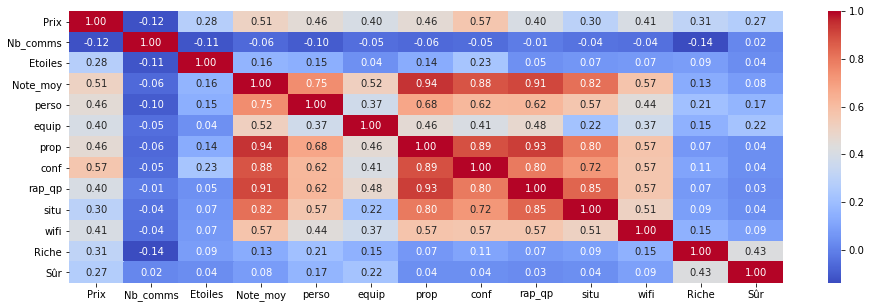

In [27]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(df_agarder.corr(), cmap='coolwarm', annot=True, fmt=".2f")

Ce graphique nous montre qu'il y a peu de corrélation entre les variables explicatives (carrés bleus), sauf entre les notes (carrés oranges). À ce niveau-là, on pourrait se demander s'il n'est pas préférable de ne conserver que la note moyenne pour faire notre régression. On décide pour le moment de conserver nos variables explicatives.

In [28]:
def plot_columns(col,df):
    for i, var_exp in enumerate(df.columns):
        if var_exp != col:
            plt.figure(figsize = (5,5))
            plt.figure(i)
            ax = sns.regplot(x=var_exp, y=col, data=df)

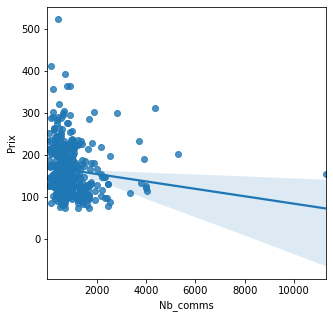

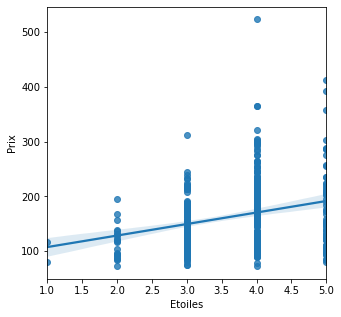

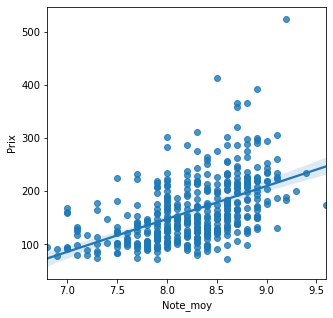

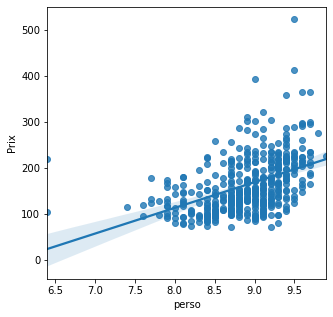

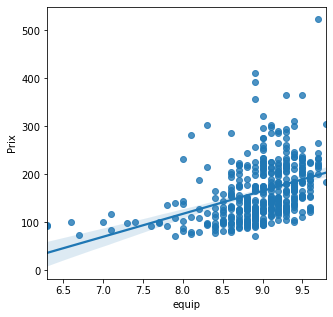

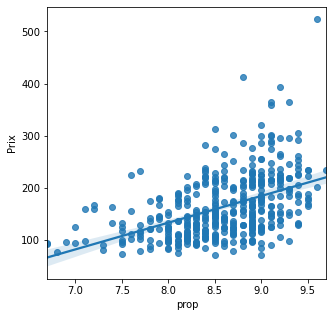

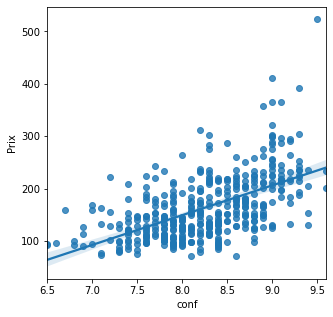

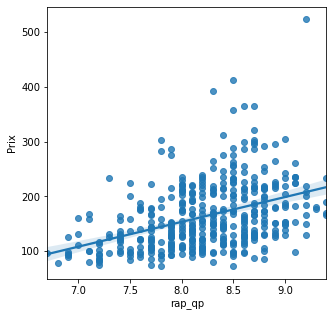

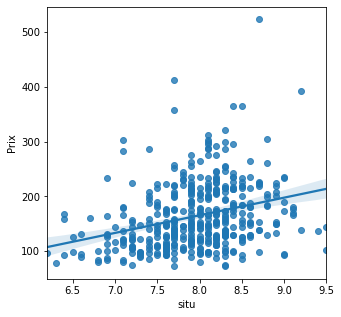

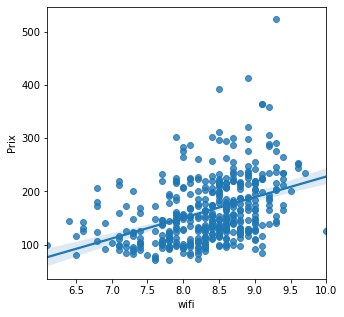

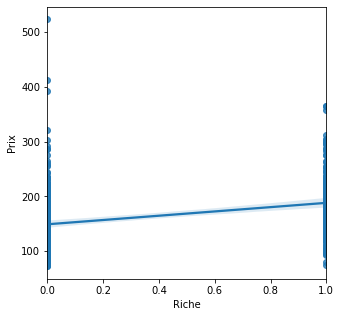

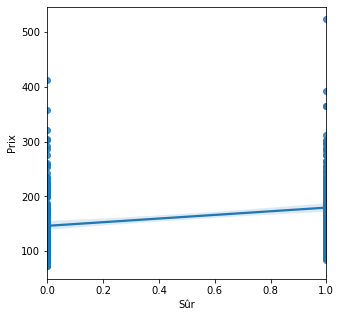

In [29]:
plot_columns('Prix', df_agarder)

Ces graphiques nous montrent que :

- Il n'y a pas de relation claire entre le nombre de commentaires et le prix de réservation. On aurait pu penser que le nombre de commentaires était un indicateur de la popularité des hôtels, et donc aurait pu influencer positivement le prix de vente, mais ce n'est finalement pas le cas.

- Chacune des notes a une relation similaire avec les prix. Ce résultat confirme que les notes selon différents critères sont corrélées, et nous encourage à ne garder que les notes moyennes. De plus, cette relation est hétéroscédastique : la dispersion des points autour des droites de régression n'est pas constante.

- La richesse et la sûreté de l'arrondissement semblent pousser légèrement les prix à la hausse.

## 3.3.3. Implémentation des modèles de régression

On essaye maintenant d'ajuster un modèle de régression à partir de ces variables explicatives. Le premier modèle conserve toutes les variables explicatives exploitables.

### Modèle 1 : inclusion de toutes les variables explicatives

In [30]:
mod = smf.ols(formula = 'Prix ~ Nb_comms + Etoiles + perso + equip + prop + conf + rap_qp + situ + wifi + Riche + Sûr', data=df_agarder)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     35.94
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           1.00e-53
Time:                        22:38:05   Log-Likelihood:                -2224.1
No. Observations:                 428   AIC:                             4472.
Df Residuals:                     416   BIC:                             4521.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -406.7532     50.470     -8.059      0.000    -505.962    -307.544
Nb_comms      -0.0046      0.003     -1.787      0.075      -0.010       0.000
Etoiles        9.4194      2.796      3.369      0.001       3.923      14.915
perso         17.3163      6.059      2.858      0.004       5.406      29.226
equip         11.8582      5.494      2.158      0.031       1.059      22.658
prop         -35.9621     14.387     -2.500      0.013     -64.242      -7.683
conf          64.9413      8.248      7.874      0.000      48.728      81.154
rap_qp        20.0579     13.170      1.523      0.129      -5.831      45.946
situ         -26.4242      7.999     -3.303      0.001     -42.148     -10.700
wifi           9.8591      4.277      2.305      0.022       1.452      18.266
Riche         16.3247      5.069      3.221      0.001       6.361      26.288
Sûr           18.2749      4.921      3.714      0.000       8.602      27.947
==============================================================================
Omnibus:                      136.431   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              576.529
Skew:                           1.351   Prob(JB):                    6.43e-126
Kurtosis:                       8.003   Cond. No.                     2.99e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On peut tout d'abord remarquer que nos variables explicatives expliquent 48% des variations des prix (c'est le $R^2$). Il semble donc y avoir d'autres caractéristiques des hôtels, absentes de notre modèle, qui auraient pu participer à la détermination des prix.

Ce modèle semble mal spécifié : en effet, certaines notes (propreté, endroit) semblent avoir une corrélation négative avec le prix, en contradiction avec nos graphiques ci-dessus. De plus, on ne peut pas dire que le nombre de commentaires et la note de rapport qualité/prix aient un impact significatif sur le prix au niveau de risque (de première espèce) 5%. On décide donc d'exclure ces variables de notre prochain modèle.

### Modèle 2 : suppression des variables explicatives non-significatives

In [31]:
smf.ols(formula = 'Prix ~ Etoiles + Note_moy + Riche + Sûr + perso + equip + wifi', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     40.48
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           1.95e-43
Time:                        22:38:51   Log-Likelihood:                -2256.7
No. Observations:                 428   AIC:                             4529.
Df Residuals:                     420   BIC:                             4562.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -491.9816     51.227     -9.604      0.000    -592.676    -391.288
Etoiles       14.8343      2.862      5.183      0.000       9.209      20.460
Note_moy      26.6865      8.216      3.248      0.001      10.536      42.837
Riche         18.8347      5.336      3.530      0.000       8.347      29.322
Sûr           14.9418      5.225      2.860      0.004       4.672      25.212
perso         12.2427      7.116      1.721      0.086      -1.744      26.230
equip         16.6318      5.441      3.057      0.002       5.937      27.327
wifi          12.9194      4.448      2.904      0.004       4.175      21.663
==============================================================================
Omnibus:                      145.114   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.559
Skew:                           1.447   Prob(JB):                    9.65e-134
Kurtosis:                       8.096   Cond. No.                         395.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ce modèle produit des résultats plus cohérents puisque chaque indicateur a une influence positive sur les prix de réservation. Toutefois, il est légitime de se demander si on doit laisser les variables 'Etoiles' et celles relatives aux notes telles quelles. En effet :

- d'une part, la variable 'Etoiles' prend des valeurs entières comprises entre 0 et 5
- d'autre part, les variables de notes prennent des valeurs comprises entre 0 et 10 (et même entre 6 et 10 dans notre jeu de données)

On peut essayer de transformer ces variables en variables catégorielles. Autrement dit, à partir d'une colonne associée à une variable explicative prenant $k$ valeurs possibles, on peut obtenir $k-1$ colonnes binaires avec des 1 si la variable explicative prend la valeur correspondante et 0 sinon. Il est nécessaire de prendre $k-1$ colonnes et non $k$, car sinon leur somme formera une variable constante égale à 1, et on aura alors une relation linéaire entre toutes ces colonnes, rendant la régression linéaire impossible.

Ici, on peut par exemple transformer la variable 'Etoiles' en 4 variables catégorielles :

- 1 ou 2 étoiles
- 3 étoiles
- 4 étoiles
- 5 étoiles

et ne pas garder la variable '3 étoiles', qui est le niveau de qualité médian de notre jeu de données. Cela nous permettra de voir l'évolution des prix lorsque l'on a affaire à des hôtels de qualité plus basse (- de 3 étoiles) ou élevée (+ de 3 étoiles). On regroupe les hôtels à 1 ou 2 étoiles, car on n'a pas assez d'hôtels à 1 étoile dans notre jeu de données, ce qui aurait pu conduire à des résultats imprécis.

De même, pour chaque critère, on regroupe :
- les notes suffisamment élevées pour dire que l'hôtel a cherché à se démarquer de la concurrence sur ce critère
- les notes suffisamment basses pour dire que l'hôtel s'est moins focalisé sur ce critère que les autres

Ces notes sont choisies de sorte qu'il y ait suffisamment d'hôtels (au moins 25) dans ces deux catégories. Il est donc utile de regarder les valeurs prises par nos variables de notes.

In [32]:
df["Etoiles"].value_counts()

4    177
3    158
5     70
2     21
1      2
Name: Etoiles, dtype: int64

In [33]:
df['cinq_etoiles'] = df['Etoiles']==5
df['quatre_etoiles'] = df['Etoiles']==4
df['moins_de_trois_etoiles'] = df['Etoiles']<3

In [34]:
df["equip"].value_counts().sort_index(ascending=False).head()

9.8     2
9.7    10
9.6    16
9.5    28
9.4    31
Name: equip, dtype: int64

In [35]:
df['equipTB'] = df['equip']>=9.5
df['equipM'] = df['equip']<=8

In [36]:
df["perso"].value_counts().sort_index(ascending=False).head()

9.9     1
9.8     1
9.7    11
9.6    16
9.5    17
Name: perso, dtype: int64

In [37]:
df["perso"].value_counts().sort_index(ascending=True).head()

6.4    2
7.4    1
7.6    2
7.7    3
7.8    2
Name: perso, dtype: int64

In [38]:
df['persoTB'] = df['perso']>=9.5
df['persoM'] = df['perso']<=8

In [39]:
df["prop"].value_counts().sort_index(ascending=False).head()

9.7     1
9.6     2
9.5     8
9.4    16
9.3    13
Name: prop, dtype: int64

In [40]:
df["prop"].value_counts().sort_index(ascending=True).head(10)

6.7    2
6.8    1
6.9    1
7.0    2
7.1    2
7.2    2
7.3    2
7.4    2
7.5    7
7.6    4
Name: prop, dtype: int64

In [41]:
df['propTB'] = df['prop']>=9.3
df['propM'] = df['prop']<=7.6

In [42]:
df["conf"].value_counts().sort_index(ascending=False).head()

9.6     2
9.5     1
9.4     4
9.3    11
9.2     9
Name: conf, dtype: int64

In [43]:
df["conf"].value_counts().sort_index(ascending=True).head(9)

6.5    2
6.6    1
6.7    1
6.8    2
6.9    3
7.0    3
7.1    4
7.2    4
7.3    8
Name: conf, dtype: int64

In [44]:
df['confTB'] = df['conf']>=9.2
df['confM'] = df['conf']<=7.3

In [45]:
df["situ"].value_counts().sort_index(ascending=False).head(6)

9.5    2
9.4    1
9.2    2
9.1    4
9.0    6
8.9    8
Name: situ, dtype: int64

In [46]:
df["situ"].value_counts().sort_index(ascending=True).head(9)

6.2    1
6.3    1
6.4    3
6.5    2
6.6    3
6.7    1
6.8    3
6.9    9
7.0    3
Name: situ, dtype: int64

In [47]:
df['situTB'] = df['situ']>=8.9
df['situM'] = df['situ']<=7

In [48]:
df["wifi"].value_counts().sort_index(ascending=False).head(6)

10.0     1
9.7      1
9.6      3
9.5      1
9.4      7
9.3     11
Name: wifi, dtype: int64

In [49]:
df["wifi"].value_counts().sort_index(ascending=True).head(8)

6.1    1
6.4    1
6.5    2
6.6    3
6.8    5
6.9    2
7.0    1
7.1    8
Name: wifi, dtype: int64

In [50]:
df['wifiTB'] = df['wifi']>=9.3
df['wifiM'] = df['wifi']<=7.1

### Modèle 3 : utilisation de variables catégorielles

In [51]:
smf.ols(formula = 'Prix ~ cinq_etoiles + quatre_etoiles + moins_de_trois_etoiles + Riche + Sûr + persoTB + persoM + equipTB + equipM + situTB + situM + wifiTB + wifiM', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     21.03
Date:                Tue, 04 Jan 2022   Prob (F-statistic):           3.50e-38
Time:                        22:41:00   Log-Likelihood:                -2258.5
No. Observations:                 428   AIC:                             4545.
Df Residuals:                     414   BIC:                             4602.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        122.3439      4.955     24.690      0.000     112.604     132.084
cinq_etoiles[T.True]              21.9810      6.977      3.151      0.002       8.267      35.695
quatre_etoiles[T.True]            36.7188      5.526      6.645      0.000      25.856      47.581
moins_de_trois_etoiles[T.True]    -9.9284     10.944     -0.907      0.365     -31.441      11.584
persoTB[T.True]                   45.9963      7.964      5.775      0.000      30.341      61.652
persoM[T.True]                    -9.3703     11.406     -0.822      0.412     -31.791      13.050
equipTB[T.True]                   24.6786      7.264      3.397      0.001      10.400      38.957
equipM[T.True]                   -36.1366     10.994     -3.287      0.001     -57.747     -14.526
situTB[T.True]                    13.6891     11.276      1.214      0.225      -8.476      35.854
situM[T.True]                     -9.5741     11.805     -0.811      0.418     -32.779      13.630
wifiTB[T.True]                    34.1971     10.544      3.243      0.001      13.471      54.923
wifiM[T.True]                    -18.2348     10.768     -1.693      0.091     -39.402       2.932
Riche                             18.0384      5.429      3.323      0.001       7.367      28.710
Sûr                               18.0693      5.218      3.463      0.001       7.812      28.327
==============================================================================
Omnibus:                      125.433   Durbin-Watson:                   1.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              396.468
Skew:                           1.342   Prob(JB):                     8.09e-87
Kurtosis:                       6.876   Cond. No.                         8.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ce modèle permet d'interpréter le prix des hôtels comme somme d'un prix fixe (interprétable comme le coût pour un couple de dormir une nuit dans une chambre d'hôtel à Paris) et de coûts supplémentaires (ou des baisses de prix) selon les caractéristiques des hôtels. Notons que dans ce modèle, le "prix fixe" est positif, donc le modèle semble mieux spécifié que les précédents.

Ce modèle appelle plusieurs interprétations :
- Il semble que les hôtels à 5 étoiles coûtent moins cher à la réservation que les hôtels à 4 étoiles, ce que l'on pouvait déjà percevoir sur le graphique de diagnostic (avec le nombre d'étoiles en abscisses et le prix en ordonnées). À première vue, ce résultat n'est pas cohérent, mais en y regardant de plus près, l'intervalle de confiance à 95% de la valeur "exacte" de l'effet marginal est comprise entre 10 et 38 pour les hôtels 5 étoiles, et entre 25 et 46 pour les hôtels 4 étoiles. Il est donc possible que l'effet marginal sur les prix d'un hôtel 5 étoiles soit plus important que pour un hôtel 4 étoiles.
- Au niveau de risque 5%, on ne peut pas dire que le fait qu'un hôtel ait moins de 3 étoiles a un effet significatif sur le prix de réservation de la chambre. Si un tel effet marginal existait, il serait négatif, ce qui semble cohérent, car par rapport à l'ensemble des hôtels de la base de données, les hôtels à moins de 3 étoiles paraissent moins bien côtés.
- Le fait d'avoir un personnel apprécié (très bonne note pour ce critère) conduit à une augmentation du prix assez marquée par rapport au cas où le personnel est moins apprécié (note moyenne ou basse). Une possibilité d'explication est que l'hôtel paie davantage son personnel ou embauche plus pour améliorer sa qualité de service, ce qui se traduit par une augmentation des prix en conséquence.
- Il en est de même pour l'équipement, pour des raisons similaires (l'équipement est payé par l'hôtel, qui répercute ensuite ces coûts sur le prix de réservation).
- Le fait d'être dans un quartier riche ou sûr augmente naturellement le prix de réservation, car ces deux caractéristiques attirent les clients. Inversement, le fait d'être dans un arrondissement pauvre ou réputé pour son insécurité peut rebuter certains clients potentiels.